In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download koryakinp/fingers
! unzip fingers.zip

In [13]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

**Importando e transformando dados**

In [16]:
artreino = os.listdir('../content/train')
arteste = os.listdir('../content/test')

artreino = ["../content/train/"+ a for a in artreino]
arteste = ["../content/test/"+ a for a in arteste]

df_treino = pd.DataFrame(artreino, columns=["caminho"])
df_teste = pd.DataFrame(arteste, columns=["caminho"])

df_treino["mao"] = df_treino["caminho"].apply(lambda x: x[-5])
df_treino["valor"] = df_treino["caminho"].apply(lambda x: x[-6])

df_teste["mao"] = df_teste["caminho"].apply(lambda x: x[-5])
df_teste["valor"] = df_teste["caminho"].apply(lambda x: x[-6])

df_treino.head()

,caminho,mao,valor
0,../content/train/26af37f1-10b6-47f0-816a-e538b...,R,0
1,../content/train/746235b8-1e26-4085-b4d3-e1105...,L,1
2,../content/train/7a4f6f0b-4bc2-4939-8e88-5fd59...,R,1
3,../content/train/9c574425-c85e-4530-9a4b-6032f...,R,4
4,../content/train/75205ca6-f469-4588-8601-1b39e...,L,5


# **Criação dos dados das imagens....**

In [17]:
geratreino = ImageDataGenerator(rotation_range = 20,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True,
                               rescale = 1./255)
gerateste = ImageDataGenerator(rescale = 1./255)

treino = geratreino.flow_from_dataframe(dataframe = df_treino,
                                       x_col = "caminho",
                                       y_col = "valor",
                                       class_mode = "categorical",
                                       color_mode = "grayscale",
                                       batch_size = 32,
                                       target_size = (128,128))
teste = gerateste.flow_from_dataframe(dataframe = df_teste,
                                       x_col = "caminho",
                                       y_col = "valor",
                                       class_mode = "categorical",
                                       color_mode = "grayscale",
                                       batch_size = 32,
                                       target_size = (128,128))

Found 18000 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.


# **Construção do modelo**

Etapas: 1. Convolução -> 2. Max Pooling -> 3. Flattening -> 4. Rede neural densa

In [ ]:
classificador = Sequential()


classificador.add(Conv2D(filters = 32,
                        kernel_size = 3,
                        activation = "relu", input_shape=(128, 128, 1)))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D(pool_size = (2,2)))

classificador.add(Conv2D(filters = 64,
                        kernel_size = 3,
                        activation = "relu"))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D(pool_size = (2,2)))


classificador.add(Conv2D(filters = 128,
                        kernel_size = 3,
                        activation = "relu"))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D(pool_size = (2,2)))


classificador.add(Conv2D(filters = 256,
                        kernel_size = 3,
                        activation = "relu"))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D(pool_size = (2,2)))


classificador.add(Flatten())


classificador.add(Dense(units = 256,
                       activation = "relu"))
classificador.add(Dropout(0.3))


classificador.add(Dense(units = 6,
                       activation = "softmax"))

classificador.compile(optimizer="adam",
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])


In [ ]:
classificador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                        

In [ ]:
callbacks = [
             ModelCheckpoint(
                 filepath="model.keras",
                 save_best_only = True,
                 monitor="val_loss"
             )
]

history = classificador.fit(
    treino,
    epochs = 10,
    validation_data = teste,
    callbacks = callbacks
)

Epoch 1/10
563/563 [==============================] - 64s 95ms/step - loss: 0.6424 - accuracy: 0.7681 - val_loss: 4.3949 - val_accuracy: 0.3347
Epoch 2/10
563/563 [==============================] - 54s 96ms/step - loss: 0.1687 - accuracy: 0.9404 - val_loss: 0.0092 - val_accuracy: 0.9961
Epoch 3/10
563/563 [==============================] - 53s 94ms/step - loss: 0.1061 - accuracy: 0.9644 - val_loss: 1.1392 - val_accuracy: 0.6758
Epoch 4/10
563/563 [==============================] - 53s 94ms/step - loss: 0.0667 - accuracy: 0.9786 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/10
563/563 [==============================] - 53s 95ms/step - loss: 0.0490 - accuracy: 0.9842 - val_loss: 5.3225 - val_accuracy: 0.3942
Epoch 6/10
563/563 [==============================] - 53s 95ms/step - loss: 0.0662 - accuracy: 0.9813 - val_loss: 0.3560 - val_accuracy: 0.8861
Epoch 7/10
563/563 [==============================] - 53s 94ms/step - loss: 0.0556 - accuracy: 0.9843 - val_loss: 4.5553e-05 - val_accur

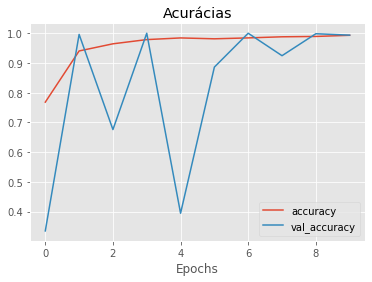

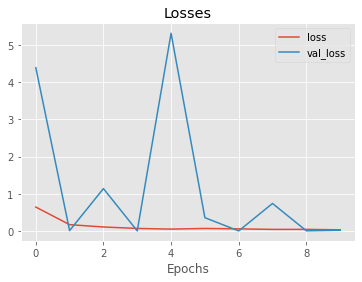

In [ ]:
ht = history.history

plt.style.use("ggplot")
plt.plot(ht["accuracy"])
plt.plot(ht["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])
plt.title("Acurácias")
plt.xlabel("Epochs")
plt.show()

plt.plot(ht["loss"])
plt.plot(ht["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("Losses")
plt.xlabel("Epochs")
plt.show()

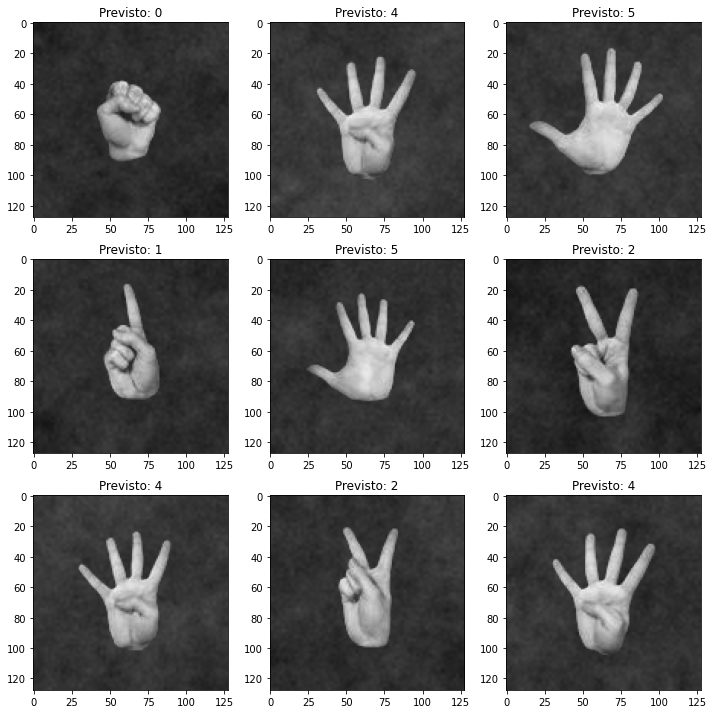

In [98]:
from itertools import product
def plotar(ax,x,y):
  cam = np.random.choice(df_teste["caminho"])
  real = cam[-6]

  imagem = cv2.imread(cam)
  imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

  imagem_p = load_img(cam, target_size=(128, 128), color_mode="grayscale")
  imagem_p = img_to_array(imagem_p)
  imagem_p /= 255
  imagem_p = np.expand_dims(imagem_p, axis=0)

  resultado = np.argmax(classificador.predict(imagem_p))

  ax[x,y].imshow(imagem)
  ax[x,y].set_title(f"Previsto: {resultado}")

fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.tight_layout()

for x,y in product([0,1,2], repeat=2):
  plotar(ax, x,y)




In [59]:
rr = classificador.evaluate(teste)

print(f"\nAcurácia: {rr[1]*100:.2f}%\nLoss: {rr[0]}")

113/113 [==============================] - 4s 26ms/step - loss: 4.5553e-05 - accuracy: 1.0000

Acurácia: 100.00%
Loss: 4.555272971629165e-05


In [89]:
classificador = load_model("modelogato.keras")

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]